# Fit a plane to the Serpens-Aquila offset image

October 12, 2022

Ramsey Karim

Tracy made a file (available in his October 2022 email) giving the offsets in Ser-Main with the high-column-density regions masked out.
I will fit his values with a plane and investigate the result.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from pathlib import Path

from astropy.io import fits

In [2]:
# Check paths
fn = os.path.join(Path.home(), "Downloads/output2.fits") # using the second file that Tracy sent
print(fn)
assert os.path.exists(fn)

/home/ramsey/Downloads/output2.fits


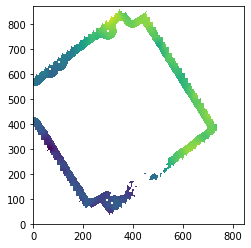

In [3]:
data, hdr = fits.getdata(fn, header=True)
outside_nan_mask = np.isfinite(data)
data[data==-100] = np.nan
plt.imshow(data, origin='lower');

The figure above shows the values in Tracy's map with the `-100` values set to `NaN`.

Next, we need to get X and Y values for each pixel in order to create (X, Y, Z) coordinates where Z will be the values in Tracy's map. We can fit a bunch of these (X, Y, Z) points with a plane using a linear regression routine.

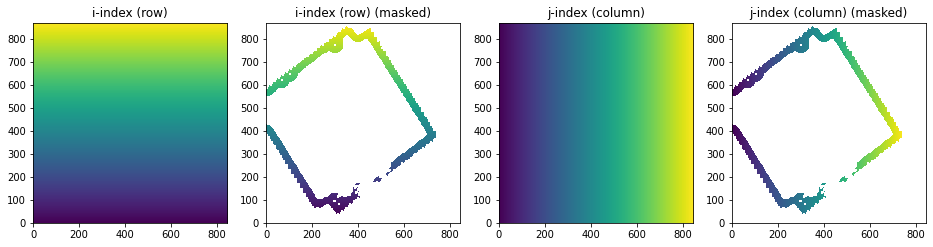

In [4]:
# Meshgrid to get array indices
ii, jj = np.mgrid[0:data.shape[0], 0:data.shape[1]]

plt.figure(figsize=(16, 8))
plt.subplot(141)
plt.imshow(ii, origin='lower')
plt.title("i-index (row)")
plt.subplot(143)
plt.imshow(jj, origin='lower')
plt.title("j-index (column)")

# Now mask out the NaNs from data
mask = np.isfinite(data)
ii = ii.astype(np.float64)
jj = jj.astype(np.float64)
ii[~mask] = np.nan
jj[~mask] = np.nan

plt.subplot(142)
plt.imshow(ii, origin='lower')
plt.title("i-index (row) (masked)")
plt.subplot(144)
plt.imshow(jj, origin='lower')
plt.title("j-index (column) (masked)");

In [5]:
# Make 1D arrays of only the good points; these are the points we will fit to
z = data[mask].ravel()
x = jj[mask].ravel()
y = ii[mask].ravel()

In [6]:
# From answer in https://stackoverflow.com/questions/57367352/how-to-fit-a-plane-to-a-3d-dataset-in-python

X_data = np.array([x, y]).reshape((-1, 2))
Y_data = z

# sklearn linear regression
from sklearn import linear_model

reg = linear_model.LinearRegression().fit(X_data, Y_data)

print("coefficients of equation of plane, (a1, a2): ", reg.coef_)

print("value of intercept, c:", reg.intercept_)

coefficients of equation of plane, (a1, a2):  [0.01814279 0.01425307]
value of intercept, c: 125.30918931245185


The regression results are printed above. The intercept at (0, 0) is a little high, we noted in our 10/12/2022 meeting.

Eventually, save the array (with the original `NaNs` as `NaNs` but the `-100`s as valid plane values).

Instead of saving the array right now, I want to investigate the plane a little more...

In [7]:
# Make another set of X and Y indices (since I masked out a lot of the old ones)
ii_full, jj_full = np.mgrid[0:data.shape[0], 0:data.shape[1]]
ii = ii_full.astype(np.float64)
jj = jj_full.astype(np.float64)
# Still mask the NaNs outside the image, but not the interior of the postage stamp (so leave the -100 area as valid)
ii[~outside_nan_mask] = np.nan
jj[~outside_nan_mask] = np.nan

In [8]:
# Plane-making function using the regression result
a, b = reg.coef_
c = reg.intercept_
def plane(i, j):
    # i is y, j is x
    return a*j + b*i + c

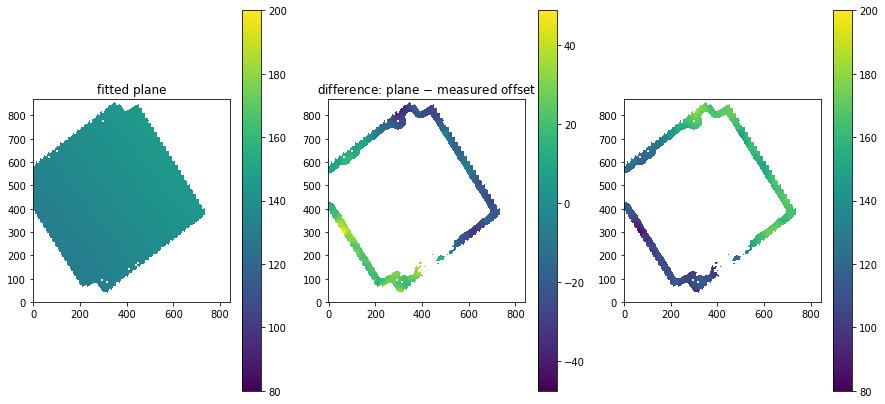

In [9]:
# Evaluate plane over the coordinate grid
model_plane = plane(ii, jj)

# Plot the fitted plane and the original offsets (Tracy's file) on the same color scale
# Plot their difference between them
plt.figure(figsize=(15, 7))
plt.subplot(131)
plt.imshow(model_plane, origin='lower', vmin=80, vmax=200)
plt.colorbar()
plt.title("fitted plane")
plt.subplot(132)
plt.imshow(model_plane - data, origin='lower')
plt.colorbar()
plt.title("difference: plane $-$ measured offset")
plt.subplot(133)
plt.imshow(data, origin='lower', vmin=80, vmax=200)
plt.colorbar();

The figure above indicates that the fit isn't too great. The fitted plane (left hand side) is much more "moderate" than the measured offsets (right hand side) which are set to the same color scale. The difference of the fitted plane minus the measured offsets, shown in the middle, shows that the difference depends on the original offset.

## Conclusion about this round of plane fitting
The figure above shows that the fit is not ideal. Below, I plot the measured offsets in 3D to figure out if they are even linear and can be fit with a plane, as well as how good the fitted plane looks by eye.
I think the 3D plot will be more useful for this than 2D because our eyes can't really translate color into distance (or mine can't anyway).

The actual offset appears to be linear but piecewise, judging by the 3D figure below; the beginning and end (SE and NW) of the linear rise are roughly flat and the middle appears to be a linear rise in offset. This might be difficult to justify, but could be relatively straightforward (but a little tedious) to implement.

<IPython.core.display.Javascript object>


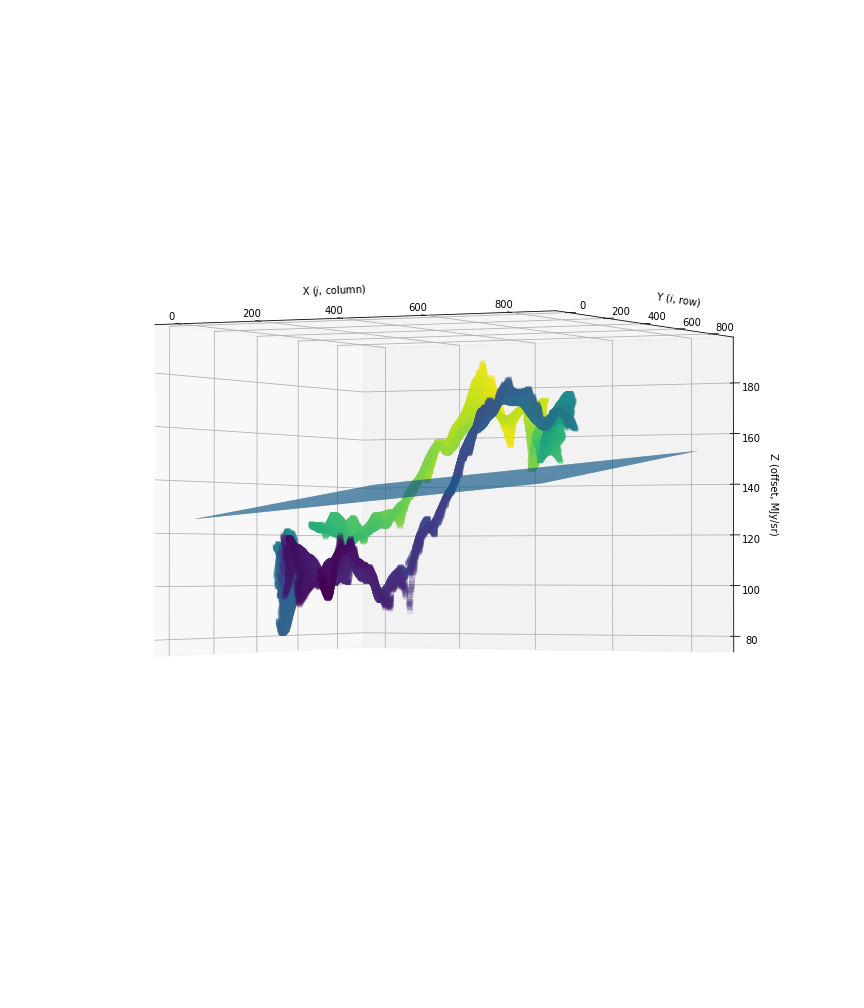

In [11]:
# Closer look at the original data (x, y, z)
%matplotlib nbagg
ax = plt.figure(figsize=(12, 14)).add_subplot(projection='3d')

ax.scatter(x, y, z, marker=',', alpha=0.1, c=y)

ax.plot_surface(jj_full, ii_full, plane(jj_full, ii_full))

ax.set_xlabel("X ($j$, column)")
ax.set_ylabel("Y ($i$, row)")
ax.set_zlabel("Z (offset, MJy/sr)")

ax.view_init(elev=1, azim=295)

In the figure above, the X and Y axes are pixel locations and Z is the offset. The scattered points are too small to see individually, but are colored purple/blue/green/yellow with increasing Y coordinate to help with visibility.
The scattered points show the measured offset around the edges of the figure&#8212;these are the finite, positive values in Tracy's FITS file.

The blue plane is the fitted result; by eye, it doesn't look too good, so this is worth some more testing.